# Issue #147 - How to model a system with a diffraction grating

https://github.com/mjhoptics/ray-optics/discussions/147

In [1]:
%matplotlib inline
#%matplotlib widget

In [2]:
# initialization
from rayoptics.environment import *
isdark = False

This is a hack of a parameter iteration function, based on the [iterate_ray()](https://ray-optics.readthedocs.io/en/latest/api/rayoptics.raytr.trace.html#rayoptics.raytr.trace.iterate_ray) function.

In [3]:
import warnings
from scipy.optimize import newton

def iterate_ray_grt(opt_model, ifcx, target, fld, wvl, grating_surface,
                    **kwargs):
    """ iterates a ray to target on interface ifcx, returns grating tilt angle

    If the iteration fails, a TraceError will be raised
    """
    ray_pkg = None
    def grating_tilt(alpha1, *args):
        nonlocal ray_pkg
        seq_model, ifcx, pt0, dist, wvl, target = args

        seq_model.ifcs[grating_surface].decenter.euler[0] = alpha1
        opt_model.update_model(src_model=seq_model)

        pt0, dir0 = opt_model['optical_spec'].ray_start_from_osp([0., 0.], fld, 'rel_pupil')
        try:
            ray, _, _ = ray_pkg = rt.trace(seq_model, pt0, dir0, wvl)

        except TraceError as ray_error:
            ray, _, _ = ray_pkg = ray_error.ray_pkg
            if ray_error.surf < ifcx:
                raise ray_error

        y_ray = ray[ifcx][mc.p][1]
#        print(y1, y_ray)
        return y_ray - target

    seq_model = opt_model.seq_model
    osp = opt_model.optical_spec

    fod = opt_model['analysis_results']['parax_data'].fod
    dist = fod.obj_dist + fod.enp_dist

    pt0, d0 = osp.obj_coords(fld)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        alpha0 = seq_model.ifcs[grating_surface].decenter.euler[0]
        try:
            alpha_new, results = newton(grating_tilt, alpha0,
                                        args=(seq_model, ifcx, pt0,
                                              dist, wvl, target),
                                        disp=False, full_output=True)
        except RuntimeError as rte:
            # if we come here, start_y is a RuntimeResults object
            # print(rte)
            alpha_new = results.root
        except TraceError:
            alpha_new = 0.0

    return alpha_new, ray_pkg

## Create optical model

In [4]:
opm = OpticalModel()
sm = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']
em = opm['ele_model']
pt = opm['part_tree']
ar = opm['analysis_results']

osp.pupil = PupilSpec(osp, key=['object', 'pupil'], value=20.0)
osp.field_of_view = FieldSpec(osp, key=['object', 'height'], flds=[0.])
osp.spectral_region = WvlSpec([('g', 0.5), ('e', 1.0), (656.2725, 0.5)], ref_wl=1)

opm.radius_mode = True

sm.gaps[0].thi=34.8
sm.add_surface([40.0, 15.0, 1.500, 62.5])
sm.add_surface([-40.0, 65.517241])
sm.gaps[2].thi=150.0
sm.add_surface([.0, -70., 'refl'])
grating_surface = sm.cur_surface

# Note that the 'bend' angle is 1/2 the total angle
# It is the amount of mirror surface tilt
sm.ifcs[grating_surface].decenter = srf.DecenterData('bend', alpha=40.)

opm.update_model()

'pupil' deprecated; use 'epd' instead.


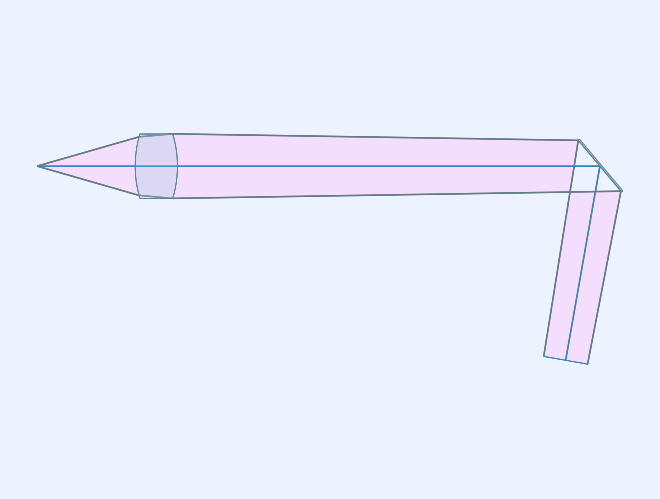

In [5]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, do_draw_rays=True, 
                        do_paraxial_layout=False, opt_model=opm).plot()


We can now add a diffraction grating to the reflector. Diffraction gratings are a subset of phase elements; [DiffractionGrating](https://ray-optics.readthedocs.io/en/latest/api/rayoptics.oprops.doe.html#rayoptics.oprops.doe.DiffractionGrating) is the type of phase element we want. I arbitrarily picked 600 lp/mm and first order (+1) for the grating. The grating is then attached to the mirror surface and the model updated.

In [6]:
grating600lp = DiffractionGrating('600L/mm grating', grating_lpmm=600., order=1)
sm.ifcs[grating_surface].phase_element = grating600lp

opm.update_model()

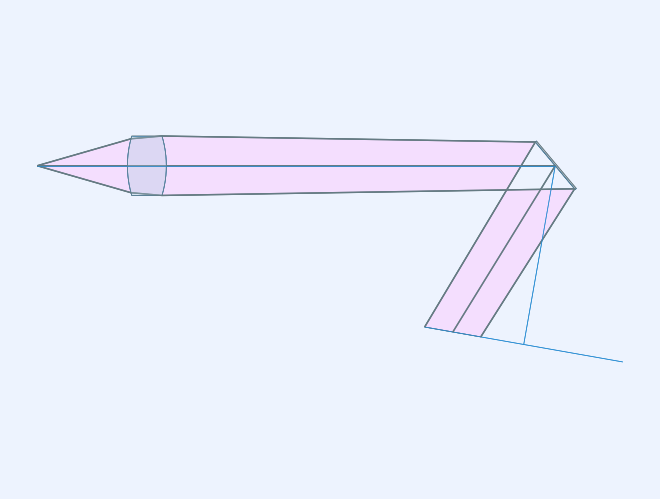

In [7]:
layout_plt1 = plt.figure(FigureClass=InteractiveLayout, do_draw_rays=True, 
                         do_paraxial_layout=False, opt_model=opm).plot()


Diffraction gratings usually don't have equal incident and diffracted angles so the Bend decenter type isn't best for this application. Instead, you make the grating surface a 'decenter and return' type, followed by a simple decenter/tilt to set the angle for the optics following the grating.

In [8]:
grating_tilt = 40.
total_angle = 60.

In [9]:
sm.cur_surface = grating_surface
sm.ifcs[sm.cur_surface].decenter = srf.DecenterData('dec and return', alpha=grating_tilt)
sm.gaps[sm.cur_surface].thi = .0

sm.add_surface([.0, -70.])
sm.ifcs[sm.cur_surface].interact_mode = 'dummy'
sm.ifcs[sm.cur_surface].decenter = srf.DecenterData('decenter', alpha=total_angle)

opm.update_model()

In [10]:
fld, wvl, foc = osp.lookup_fld_wvl_focus(0)

I modified a version of `iterate_ray` to change the grating angle to bring the central wavelength to the center of the image plane.

In [11]:
alpha_sln, ray_pkg = iterate_ray_grt(opm, 5, 0., fld, wvl, grating_surface)

The [list_sg()](https://ray-optics.readthedocs.io/en/latest/api/rayoptics.seq.sequential.html#rayoptics.seq.sequential.SequentialModel.list_sg) method lists the model including y decenter and alpha tilt output.

In [12]:
sm.list_sg()

               r               mode              type          y       alpha
                       t           medium
  Obj:      0.00000                 
                     34.8000          air
    1:      40.0000                 
                     15.0000      500.625
    2:     -40.0000                 
                     150.000          air
    3:      0.00000          reflect     dec and return     0.0000     40.904
                     0.00000          air
    4:      0.00000                            decenter     0.0000     60.000
                    -70.0000          air
  Img:     -0.00000                 


The [listobj()](https://ray-optics.readthedocs.io/en/latest/api/rayoptics.html#rayoptics.listobj) function can be used with many objects to get a "full" listing of their contents.

In [13]:
listobj(sm.ifcs[grating_surface])

reflect
profile: Spherical
c=0.0,   r=0.0
600L/mm grating: transmit order: 1, grating_lpmm: 600.0
grating_normal: [0. 1. 0.]
decenter type: dec and return
decenter: [0. 0. 0.]
euler angles: [40.90409256  0.          0.        ]
surface_od=12.10810797032886



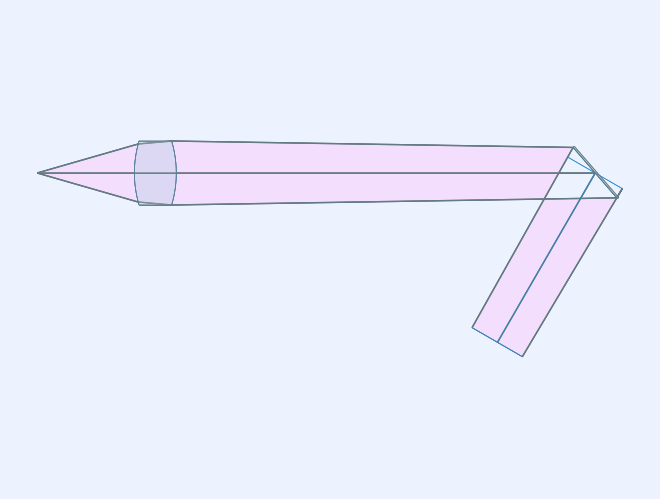

In [14]:
layout_plt2 = plt.figure(FigureClass=InteractiveLayout, do_draw_rays=True, 
                         do_paraxial_layout=False, opt_model=opm).plot()

For visualizing grating systems, it is useful to draw rays for different wavelengths vs fields of view. The function below creates ray fans at different wavelengths for use with the lens layout.

In [15]:
from rayoptics.elem.layout import RayFanBundle
def create_ray_fan_vs_wvl(fig, opt_model, num_rays=21):
    ray_fan_bundles = []
    system_length, start_offset = fig.sl_so
    fov = opt_model['optical_spec']['fov']
    fi = 0
    fld = fov.fields[fi]
    fld_label = fov.index_labels[fi]
    wvls = opt_model['optical_spec']['wvls']
    for wl, clr in zip(wvls.wavelengths, wvls.render_colors):
        rayfan = RayFan(opt_model, f=fld, wl=wl, xyfan='y', num_rays=num_rays,
                        label=fld_label, color=clr)
        rb = RayFanBundle(opt_model, rayfan, start_offset)
        ray_fan_bundles.append(rb)
    return ray_fan_bundles

In [16]:
entity_factory = create_ray_fan_vs_wvl, (opm,), {'num_rays': 3}
eflist = [entity_factory]

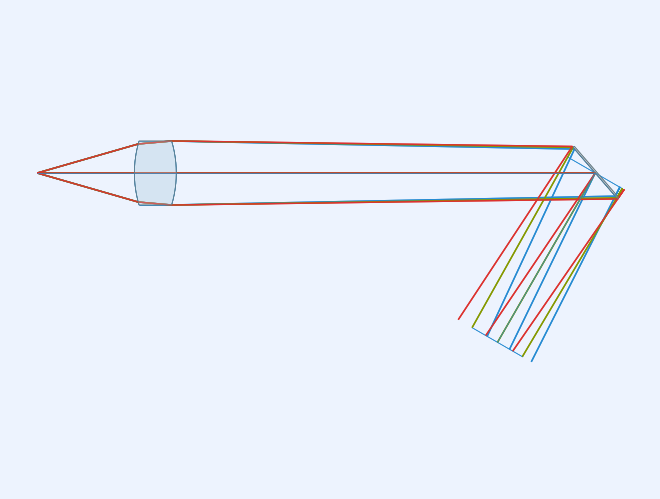

In [17]:
layout_plt3 = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, do_draw_rays=False, 
                         do_draw_beams=False, do_draw_edge_rays=False, 
                         entity_factory_list=eflist).plot()

One can change the order of the grating to 2nd order and change the grating angle to bring the central wavelength to the center of the image plane. Note the rays are spread farther apart.

In [18]:
sm.ifcs[grating_surface].phase_element.order = 2
sm.ifcs[grating_surface].decenter.euler[0] = 53

opm.update_model()

In [19]:
alpha_sln, ray_pkg = iterate_ray_grt(opm, 5, 0., fld, wvl, grating_surface)

In [20]:
sm.list_sg()

               r               mode              type          y       alpha
                       t           medium
  Obj:      0.00000                 
                     34.8000          air
    1:      40.0000                 
                     15.0000      500.625
    2:     -40.0000                 
                     150.000          air
    3:      0.00000          reflect     dec and return     0.0000     52.230
                     0.00000          air
    4:      0.00000                            decenter     0.0000     60.000
                    -70.0000          air
  Img:     -0.00000                 


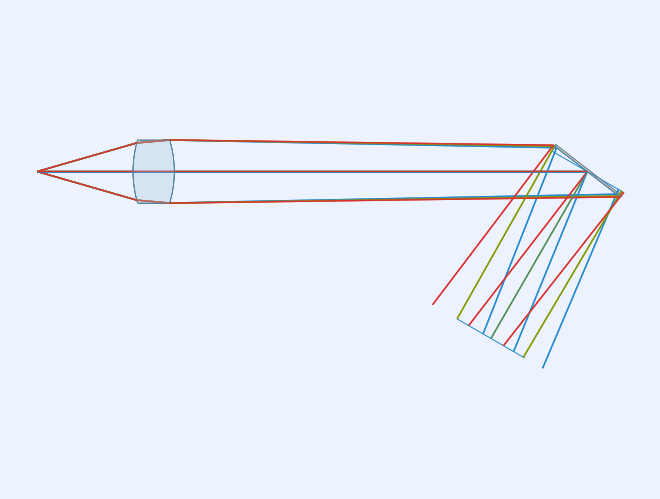

In [21]:
layout_plt4 = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, do_draw_rays=False, 
                         do_draw_beams=False, do_draw_edge_rays=False, 
                         entity_factory_list=eflist).plot()

One can also trace in the zeroth order and see that the grating angle matches what a plane reflection would do.

In [22]:
sm.ifcs[grating_surface].phase_element.order = 0
sm.ifcs[grating_surface].decenter.euler[0] = total_angle/2

opm.update_model()

In [23]:
sm.list_sg()

               r               mode              type          y       alpha
                       t           medium
  Obj:      0.00000                 
                     34.8000          air
    1:      40.0000                 
                     15.0000      500.625
    2:     -40.0000                 
                     150.000          air
    3:      0.00000          reflect     dec and return     0.0000     30.000
                     0.00000          air
    4:      0.00000                            decenter     0.0000     60.000
                    -70.0000          air
  Img:     -0.00000                 


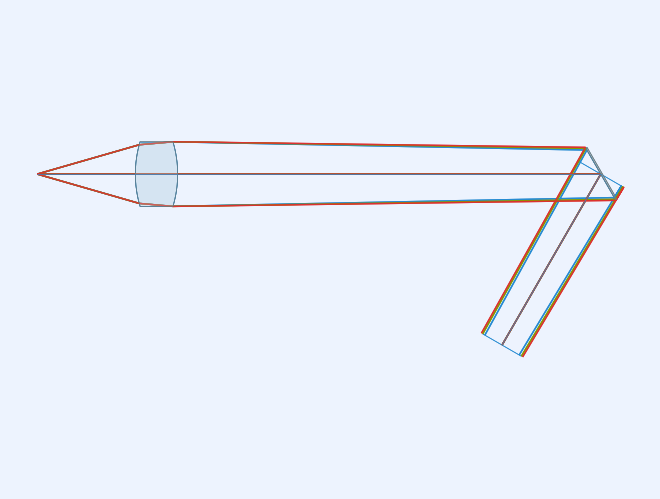

In [24]:
layout_plt5 = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, do_draw_rays=False, 
                         do_draw_beams=False, do_draw_edge_rays=False, 
                         entity_factory_list=eflist).plot()